# Exemplo Balke-Pearl: [Balke-Pearl](https://drive.google.com/drive/folders/1mLHLrXJI1-z0eMy68Bkljw4gdDImSm0q)

In [72]:
# Imports
import logging

import bcause.util.domainutils as dutils
import networkx as nx
import numpy as np
import pandas as pd
from bcause.factors import DeterministicFactor, MultinomialFactor
from bcause.inference.causal.elimination import CausalVariableElimination
from bcause.inference.causal.multi import EMCC
from bcause.models.cmodel import StructuralCausalModel
from matplotlib import pyplot as plt
from bcause.util import randomUtil

logging.disable(level=logging.CRITICAL)

## Definindo os mecanismos corretos

### Dados e Grafo

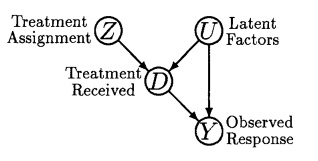

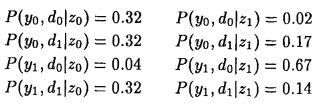

In [73]:
# Data
df = pd.read_csv('../data/balke_pearl.csv').rename(columns={'X': 'D'})
df

,Z,D,Y
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
995,1,1,1
996,1,1,1
997,1,1,1
998,1,1,1


Variável V deve ser adicionada, para que o problema seja resolvido.

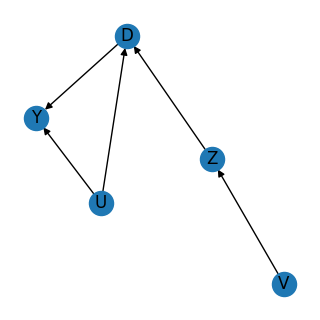

In [74]:
# DAG
dag = nx.DiGraph([('D', 'Y'), ('Z', 'D'), ('U', 'D'), ('U', 'Y'), ('V', 'Z')])
plt.figure(1, (3, 3))
nx.draw(dag, with_labels=True)

### Domínios e Mecanismos

In [75]:
domains = dict(D=[0, 1], Z=[0, 1], Y=[0, 1], U=list(np.arange(16)), V=[0, 1])

In [76]:
domz = dutils.var_parents_domain(domains, dag, 'Z')
print(domz)


domd = dutils.var_parents_domain(domains, dag, 'D')
print(domd)


domy = dutils.var_parents_domain(domains, dag, 'Y')
print(domy)


domu = dutils.subdomain(domains, 'U')
print(domu)


domv = dutils.subdomain(domains, 'V')
print(domv)

{'V': [0, 1], 'Z': [0, 1]}
{'Z': [0, 1], 'U': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'D': [0, 1]}
{'D': [0, 1], 'U': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Y': [0, 1]}
{'U': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
{'V': [0, 1]}


In [77]:
fz = DeterministicFactor(domz, [0, 1], left_vars=['Z'])
fd = DeterministicFactor(
    domd, values=[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
                  1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], left_vars=['D'], right_vars=['Z', 'U'])
fy = DeterministicFactor(
    domy, values=[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
                  1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0], left_vars=['Y'], right_vars=['D', 'U'])
pu = MultinomialFactor(domu, [1/16]*16)
pv = MultinomialFactor(domv, [0.9, 0.1])

In [78]:
model = StructuralCausalModel(dag, [fd, fy, fz, pu, pv])
model

<StructuralCausalModel (D:2,Y:2,Z:2|U:16,V:2), dag=[D|Z:U][Y|D:U][Z|V][U][V]>

In [79]:
model.factors

{'D': <MultinomialFactor P(D|Z,U), cardinality = (Z:2,U:16,D:2), values=[0.0,1.0,0.0,1.0,...,0.0]>,
 'Y': <MultinomialFactor P(Y|D,U), cardinality = (D:2,U:16,Y:2), values=[0.0,1.0,1.0,0.0,...,0.0]>,
 'Z': <MultinomialFactor P(Z|V), cardinality = (V:2,Z:2), values=[1.0,0.0,0.0,1.0]>,
 'U': <MultinomialFactor P(U), cardinality = (U:16), values=[0.0625,0.0625,0.0625,0.0625,...,0.0625]>,
 'V': <MultinomialFactor P(V), cardinality = (V:2), values=[0.9,0.1]>}

### EMCC e Resultados

In [59]:
inf = EMCC(model, df, max_iter=100, num_runs=20)
do1 = inf.causal_query('Y', {'D': 1})
do0 = inf.causal_query('Y', {'D': 0})

In [60]:
ace_low = do1.values[1]-do0.values[1]
ace_high = do1.values[-1]-do0.values[-1]
print(f'{ace_low} <= ACE <= {ace_high}')

-0.1940166168486005 <= ACE <= -0.14807970913093804


In [61]:
inf.model.factors

{'D': <MultinomialFactor P(D|Z,U), cardinality = (Z:2,U:16,D:2), values=[0.0,1.0,0.0,1.0,...,0.0]>,
 'Y': <MultinomialFactor P(Y|D,U), cardinality = (D:2,U:16,Y:2), values=[0.0,1.0,1.0,0.0,...,0.0]>,
 'Z': <MultinomialFactor P(Z|V), cardinality = (V:2,Z:2), values=[1.0,0.0,0.0,1.0]>,
 'U': <MultinomialFactor P(U), cardinality = (U:16), values=[0.0026636526468928837,0.033866461018987964,0.005936289313429536,0.005039762239030249,...,0.0128912594363624]>,
 'V': <MultinomialFactor P(V), cardinality = (V:2), values=[0.9,0.1]>}

O método sobrescreve as probabilidades das exógenas, mas não sobrescreve os mecanismos das endógenas em relação aos pais. Portanto, deve-se indexar os mecanismos das variáveis pelas latentes "na mão" para que o método funcione.

Mesmo assim, o resultado foi um intervalo muito menor que o artigo do Balke-Pearl, não necessariamente confiável, mas contido no intervalo correto: $-0,23<ACE<-0,15$.

## Mecanismos aleatórios

Para provar que ele não sobrescreve os mecanismos, o exemplo a seguir segue os mesmos passos do anterior, porém define mecanismos aleatórios.

## Dados e Grafo

In [62]:
# Data
df = pd.read_csv('../data/balke_pearl.csv').rename(columns={'X': 'D'})
df

,Z,D,Y
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
995,1,1,1
996,1,1,1
997,1,1,1
998,1,1,1


Variável V deve ser adicionada, para que o problema seja resolvido.

In [63]:
# DAG
dag = nx.DiGraph([('D', 'Y'), ('Z', 'D'), ('U', 'D'), ('U', 'Y'), ('V', 'Z')])
# nx.draw(dag, with_labels=True)

### Domínios e Mecanismos

In [64]:
domains = dict(D=[0, 1], Z=[0, 1], Y=[0, 1], U=list(np.arange(16)), V=[0, 1])

In [65]:
domz = dutils.var_parents_domain(domains, dag, 'Z')
print(domz)


domd = dutils.var_parents_domain(domains, dag, 'D')
print(domd)


domy = dutils.var_parents_domain(domains, dag, 'Y')
print(domy)


domu = dutils.subdomain(domains, 'U')
print(domu)


domv = dutils.subdomain(domains, 'V')
print(domv)

{'V': [0, 1], 'Z': [0, 1]}
{'Z': [0, 1], 'U': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'D': [0, 1]}
{'D': [0, 1], 'U': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Y': [0, 1]}
{'U': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
{'V': [0, 1]}


In [66]:
np.random.seed(0)

fz = DeterministicFactor(domz, [0, 1], left_vars=['Z'])
fd = DeterministicFactor(domd, values=list(
    np.random.choice(2, 32)), left_vars=['D'])
fy = DeterministicFactor(domy, values=list(
    np.random.choice(2, 32)), left_vars=['Y'])
pu = MultinomialFactor(domu, [1/16]*16)
pv = MultinomialFactor(domv, [0.9, 0.1])

In [67]:
model = StructuralCausalModel(dag, [fd, fy, fz, pu, pv])
model

<StructuralCausalModel (D:2,Y:2,Z:2|U:16,V:2), dag=[D|Z:U][Y|D:U][Z|V][U][V]>

In [68]:
model.factors

{'D': <MultinomialFactor P(D|Z,U), cardinality = (Z:2,U:16,D:2), values=[1.0,0.0,0.0,1.0,...,0.0]>,
 'Y': <MultinomialFactor P(Y|D,U), cardinality = (D:2,U:16,Y:2), values=[0.0,1.0,1.0,0.0,...,0.0]>,
 'Z': <MultinomialFactor P(Z|V), cardinality = (V:2,Z:2), values=[1.0,0.0,0.0,1.0]>,
 'U': <MultinomialFactor P(U), cardinality = (U:16), values=[0.0625,0.0625,0.0625,0.0625,...,0.0625]>,
 'V': <MultinomialFactor P(V), cardinality = (V:2), values=[0.9,0.1]>}

### EMCC e Resultados

In [69]:
inf = EMCC(model, df, max_iter=100, num_runs=20)
do1 = inf.causal_query('Y', {'D': 1})
do0 = inf.causal_query('Y', {'D': 0})

In [70]:
ace_low = do1.values[1]-do0.values[1]
ace_high = do1.values[-1]-do0.values[-1]
print(f'{min(ace_low, ace_high)} <= ACE <= {max(ace_low, ace_high)}')

-0.5084678003917922 <= ACE <= -0.4030636909284297


In [71]:
inf.model.factors

{'D': <MultinomialFactor P(D|Z,U), cardinality = (Z:2,U:16,D:2), values=[1.0,0.0,0.0,1.0,...,0.0]>,
 'Y': <MultinomialFactor P(Y|D,U), cardinality = (D:2,U:16,Y:2), values=[0.0,1.0,1.0,0.0,...,0.0]>,
 'Z': <MultinomialFactor P(Z|V), cardinality = (V:2,Z:2), values=[1.0,0.0,0.0,1.0]>,
 'U': <MultinomialFactor P(U), cardinality = (U:16), values=[0.024472792986647066,0.016194913750332857,0.29452814572691144,1.3160562259709766e-09,...,0.03919760856063115]>,
 'V': <MultinomialFactor P(V), cardinality = (V:2), values=[0.9,0.1]>}